# Import Modules

In [190]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from torch import Tensor
from numpy import ndarray
from typing import Type

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import Data and Data Processing

In [ ]:
tree = ET.parse("./data/O-A0038-003.xml")
root = tree.getroot()
ns = {"ns": "urn:cwa:gov:tw:cwacommon:0.1"}

# template data
data = np.array([
    [float(temp) for temp in row.split(',')]
    for row in root.find("./ns:dataset/ns:Resource/ns:Content", ns).text.split('\n')
])

# long_min, long_max, lat_min, lat_max, template_min, template_max
dataRange = [
    float(root.find("./ns:dataset/ns:GeoInfo/ns:{0}".format(tag), ns).text)
    for tag in [
        "BottomLeftLongitude",
        "TopRightLongitude",
        "BottomLeftLatitude",
        "TopRightLatitude"
    ]
] + [
    np.min(np.where(data == -999, np.inf, data)),
    np.max(data)
]

# long & lat grid
lat_grid, long_grid = np.mgrid[dataRange[3]:dataRange[2]:120j, dataRange[0]:dataRange[1]:67j]
ll_grid = np.concat((long_grid[..., np.newaxis], lat_grid[..., np.newaxis]), axis=-1)

# Classification dataset (long, lat, label)
classData = np.array([
    [long_grid[i, j], lat_grid[i, j], 0 if data[i, j] == -999 else 1]
    for i in range(120)
    for j in range(67)
])

# Regression dataset (long, lat, value)
regData = np.array([
    [long_grid[i, j], lat_grid[i, j], data[i, j]]
    for i in range(120)
    for j in range(67)
    if data[i, j] != -999
])

### Normalize Data

In [192]:
def normalize(x: float, _min: float, _max: float) -> float:
    return (x - _min) / (_max - _min)

def unnormalize(x: float, _min: float, _max: float) -> float:
    return x * (_max - _min) + _min

# Classification dataset
classData_N = np.zeros((len(classData), len(classData[0])))
classData_N[:, 0] = normalize(classData[:, 0], dataRange[0], dataRange[1])
classData_N[:, 1] = normalize(classData[:, 1], dataRange[2], dataRange[3])
classData_N[:, 2] = classData[:, 2]

# Regression dataset
regData_N = np.zeros((len(regData), len(regData[0])))
regData_N[:, 0] = normalize(regData[:, 0], dataRange[0], dataRange[1])
regData_N[:, 1] = normalize(regData[:, 1], dataRange[2], dataRange[3])
regData_N[:, 2] = normalize(regData[:, 2], dataRange[4], dataRange[5])

# DataSet

In [ ]:
def tvt_split(arr: ndarray) -> tuple:
    idx   = np.random.permutation(len(arr))
    n     = int(0.1*len(arr))
    train = arr[idx[2*n:]]
    valid = arr[idx[:n]]
    test  = arr[idx[n:2*n]]
    return train, valid, test

def toTensor(arr: ndarray) -> Tensor:
    return torch.tensor(arr, dtype=torch.float32)

class BasicDataSet(torch.utils.data.Dataset):
    def __init__(self, _data: ndarray) -> None:
        self.data : ndarray = _data.copy()
        self.X    : ndarray = self.data[:, :2]
        self.X_t  : Tensor  = toTensor(self.X)
    
    def __len__(self):
        return len(self.data)

class NormalDataSet(BasicDataSet):
    def __init__(self, _data: ndarray) -> None:
        super(NormalDataSet, self).__init__(_data)
        self.Y  : ndarray = self.data[:, 2:]
        self.Y_t: Tensor  = toTensor(self.Y)
    
    def __getitem__(self, idx):
        return self.X_t[idx], self.Y_t[idx]

class OneHotDataSet(BasicDataSet):
    def __init__(self, _data: ndarray) -> None:
        super(OneHotDataSet, self).__init__(_data)
        self.Y  : ndarray = np.array([[1, 0] if row[2] == 0 else [0, 1] for row in self.data])
        self.Y_t: Tensor  = toTensor(self.Y)
    
    def __getitem__(self, idx):
        return self.X_t[idx], self.Y_t[idx]

class DataSet:
    def __init__(self, _data: ndarray, _bds: Type[BasicDataSet], _batchSize: int) -> None:
        self.data : ndarray = _data.copy()
        self.train: Type[BasicDataSet]
        self.valid: Type[BasicDataSet]
        self.test : Type[BasicDataSet]
        self.train, self.valid, self.test = tuple(_bds(splitdata) for splitdata in tvt_split(self.data))

        self.loader = torch.utils.data.DataLoader(self.train, batch_size=_batchSize, shuffle=True)

classDS = DataSet(classData_N, NormalDataSet, 128)
regDS   = DataSet(regData_N  , NormalDataSet, 128)

# Network

In [230]:
class ClassModel(nn.Module):
    def __init__(self) -> None:
        super(ClassModel, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, X):
        return self.seq(X)

class RegModel(nn.Module):
    def __init__(self) -> None:
        super(RegModel, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(2, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    
    def forward(self, X):
        return self.seq(X)

# Training Function

In [195]:
def trainingFunc(net, criterion, optimizer, trainEpoch: int, DS: DataSet) -> tuple:
    trainlosslist = []
    validlosslist = []

    print("┌───────┬───────────┬───────────┐")
    print("│ Epoch │ trainLoss │ validLoss │")
    print("├───────┼───────────┼───────────┤")

    for epoch in range(trainEpoch):
        # train data
        for batch_X, batch_Y in DS.loader:
            optimizer.zero_grad()
            y_train = net(batch_X)
            trainloss = criterion(y_train, batch_Y)
            trainloss.backward()
            optimizer.step()

        # valid data
        y_valid = net(DS.valid.X_t)
        validloss = criterion(y_valid, DS.valid.Y_t)

        # record
        trainlosslist.append(trainloss.item())
        validlosslist.append(validloss.item())

        if epoch % (trainEpoch // 10) == 0:
            print("│ {0:5d} │ {1:9.5f} │ {2:9.5f} │".format(epoch, trainloss.item(), validloss.item()))
    
    print("| Final | {0:9.5f} │ {1:9.5f} │".format(trainlosslist[-1], validlosslist[-1]))
    print("└───────┴───────────┴───────────┘")
    return trainlosslist, validlosslist

def drawLossCurve(trainlosslist: list, validlosslist: list) -> None:
    epochlist = np.arange(len(trainlosslist))
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    axes[0].plot(epochlist, trainlosslist, label='trainLoss')
    axes[0].plot(epochlist, validlosslist, label='validLoss')
    axes[0].legend()
    axes[0].grid(True)
    axes[0].set_title("Loss curves")

    axes[1].plot(epochlist, trainlosslist, label='trainLoss')
    axes[1].plot(epochlist, validlosslist, label='validLoss')
    axes[1].set_yscale('log')
    axes[1].legend()
    axes[1].grid(True)
    axes[1].set_title("Loss curves (logarithmic scale)")

    plt.tight_layout()
    plt.show()

# Training

## Classification

┌───────┬───────────┬───────────┐
│ Epoch │ trainLoss │ validLoss │
├───────┼───────────┼───────────┤
│     0 │   0.63437 │   0.65336 │
│    50 │   0.01637 │   0.05686 │
│   100 │   0.06986 │   0.05665 │
│   150 │   0.02484 │   0.05528 │
│   200 │   0.01710 │   0.05169 │
│   250 │   0.01857 │   0.04580 │
│   300 │   0.01558 │   0.04779 │
│   350 │   0.01390 │   0.04134 │
│   400 │   0.02670 │   0.04324 │
│   450 │   0.00582 │   0.04116 │
| Final |   0.01844 │   0.04515 │
└───────┴───────────┴───────────┘


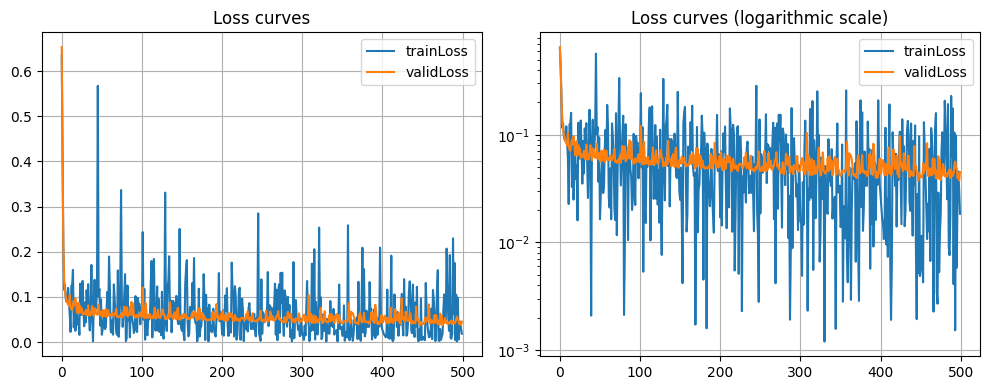

In [231]:
net_cls        = ClassModel()
criterion_cls  = nn.BCELoss()
optimizer_cls  = torch.optim.Adam(net_cls.parameters(), lr=0.001)
trainEpoch_cls = 500

trainlosslist_cls, validlosslist_cls = trainingFunc(net_cls, criterion_cls, optimizer_cls, trainEpoch_cls, classDS)
drawLossCurve(trainlosslist_cls, validlosslist_cls)

## Regression

┌───────┬───────────┬───────────┐
│ Epoch │ trainLoss │ validLoss │
├───────┼───────────┼───────────┤
│     0 │   0.03339 │   0.03595 │
│   100 │   0.00785 │   0.00886 │
│   200 │   0.00694 │   0.00979 │
│   300 │   0.00633 │   0.00912 │
│   400 │   0.00697 │   0.00886 │
│   500 │   0.00519 │   0.00840 │
│   600 │   0.00580 │   0.00823 │
│   700 │   0.00439 │   0.00768 │
│   800 │   0.00380 │   0.00725 │
│   900 │   0.00261 │   0.00727 │
| Final |   0.00463 │   0.00717 │
└───────┴───────────┴───────────┘


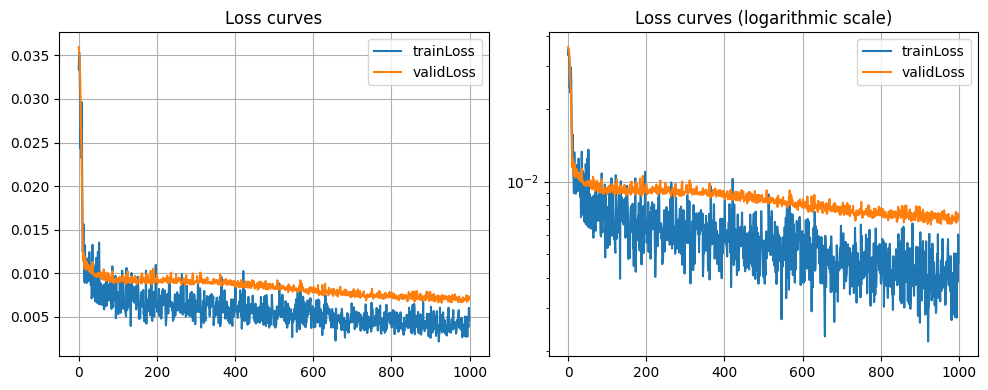

In [197]:
net_reg        = RegModel()
criterion_reg  = nn.MSELoss()
optimizer_reg  = torch.optim.Adam(net_reg.parameters(), lr=0.001)
trainEpoch_reg = 1000

trainlosslist_reg, validlosslist_reg = trainingFunc(net_reg, criterion_reg, optimizer_reg, trainEpoch_reg, regDS)
drawLossCurve(trainlosslist_reg, validlosslist_reg)

# Test Case

In [198]:
y_cls = net_cls(classDS.test.X_t)
loss_cls = criterion_cls(y_cls, classDS.test.Y_t)

y_reg = net_reg(regDS.test.X_t)
loss_reg = criterion_reg(y_reg, regDS.test.Y_t)

print("class: {0:.5f}".format(loss_cls.item()))
print("reg  : {0:.5f}".format(loss_reg.item()))

class: 0.01269
reg  : 0.00686


# Complete Black Box

It will be passed in unnormalized latitude and longitude data and will pass out unnormalized results

In [227]:
class Classifier:
    def __init__(self, _input: ndarray) -> None:
        self.input  : ndarray = _input.copy()
        self.input_N: ndarray = self.input.copy()
        self.input_N[..., 0]  = normalize(self.input[..., 0], dataRange[0], dataRange[1])
        self.input_N[..., 1]  = normalize(self.input[..., 1], dataRange[2], dataRange[3])
        self.input_t: Tensor  = toTensor(self.input_N)

        self.result: ndarray
    
    def forward(self) -> ndarray:
        if(self.input.ndim == 2):
            self.forward_list()
        elif(self.input.ndim == 3):
            self.forward_grid()
        else:
            print("ndim error!")
        return self.result
    
    def forward_list(self) -> None:
        res_t = net_cls(self.input_t)
        res_n = res_t.detach().numpy().squeeze()
        res_l = [0 if row < 0.5 else 1 for row in res_n]
        self.result = np.array(res_l)
    
    def forward_grid(self) -> None:
        res_l = []
        for row in self.input_t:
            res_l.append(list(net_cls(row).detach().numpy().squeeze()))
        res_n = np.array(res_l)
        self.result = np.where(res_n < 0.5, 0, 1)

class Regressor:
    def __init__(self, _input: ndarray) -> None:
        self.input  : ndarray = _input.copy()
        self.input_N: ndarray = self.input.copy()
        self.input_N[..., 0]  = normalize(self.input[..., 0], dataRange[0], dataRange[1])
        self.input_N[..., 1]  = normalize(self.input[..., 1], dataRange[2], dataRange[3])
        self.input_t: Tensor  = toTensor(self.input_N)

        self.result: ndarray
    
    def forward(self) -> ndarray:
        if(self.input.ndim == 2):
            self.forward_list()
        elif(self.input.ndim == 3):
            self.forward_grid()
        else:
            print("ndim error!")
        return self.result
    
    def forward_list(self) -> None:
        res_t = net_reg(self.input_t)
        res_n = res_t.detach().numpy().squeeze()
        self.result = np.array(unnormalize(res_n, dataRange[4], dataRange[5]))
    
    def forward_grid(self) -> None:
        res_l = []
        for row in self.input_t:
            res_l.append(list(net_reg(row).detach().numpy().squeeze()))
        res_n = np.array(res_l)
        self.result = np.array(unnormalize(res_n, dataRange[4], dataRange[5]))

# Display Data Preparation

In [234]:
size_times = 4
x_size, y_size = 67*size_times, 120*size_times
y, x = np.mgrid[dataRange[3]:dataRange[2]:y_size*1j, dataRange[0]:dataRange[1]:x_size*1j]
grid = np.concat((x[..., np.newaxis], y[..., np.newaxis]), axis=-1)

# class origin
plot_data_1 = np.where(data==-999, np.nan, 0)

# class result
clser = Classifier(grid)
clsres = clser.forward()
plot_data_2 = np.where(clsres == 0, np.nan, 0)

# reg origin
plot_data_3 = np.where(data==-999, np.nan, data)

# reg result
reger = Regressor(grid)
regres = reger.forward()
plot_data_4 = np.where(clsres == 0, np.nan, regres)

# ticks
xtick_org = list(range(0, 67, 20))
ytick_org = list(range(0, 120, 20))
xtick_label_org = [f"{long_grid[0, i]:.2f}" for i in xtick_org]
ytick_label_org = [f"{lat_grid[-i-1, 0]:.2f}" for i in ytick_org]

xtick_res = list(range(0, x_size, 20*size_times))
ytick_res = list(range(0, y_size, 20*size_times))
xtick_label_res = [f"{long_grid[0, i//size_times]:.2f}" for i in xtick_res]
ytick_label_res = [f"{lat_grid[-i//size_times-1, 0]:.2f}" for i in ytick_res]

# Display Result

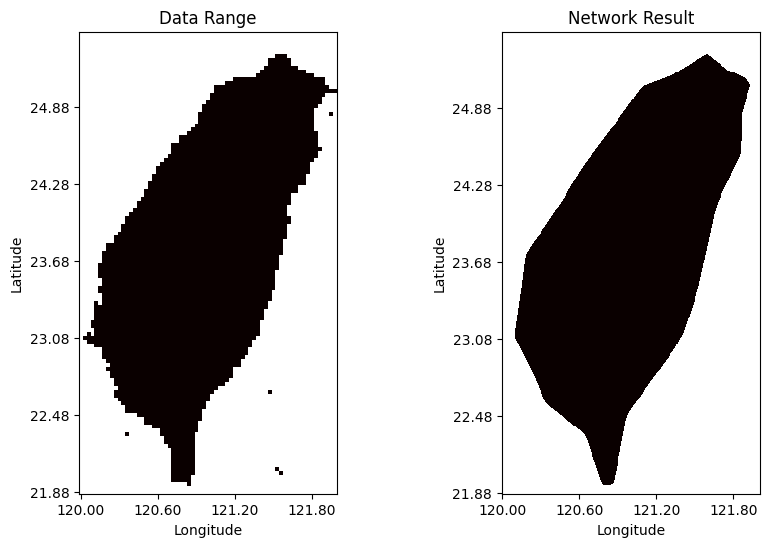

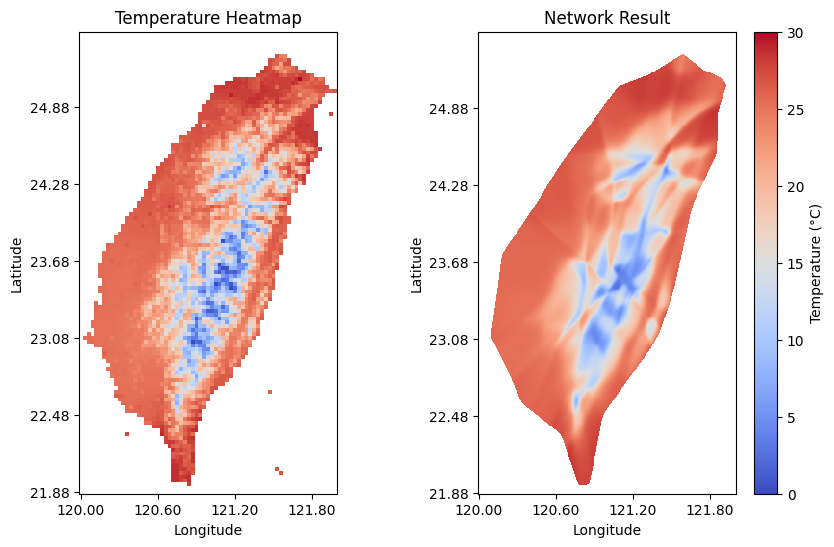

In [236]:
fig1, axes1 = plt.subplots(1, 2, figsize=(10, 6))

im1 = axes1[0].imshow(plot_data_1, origin='lower', cmap='hot', 
                      vmin=0, vmax=30, interpolation='nearest')
axes1[0].set_title("Data Range")
axes1[0].set_xlabel("Longitude")
axes1[0].set_ylabel("Latitude")
axes1[0].set_xticks(xtick_org)
axes1[0].set_yticks(ytick_org)
axes1[0].set_xticklabels(xtick_label_org)
axes1[0].set_yticklabels(ytick_label_org)

im2 = axes1[1].imshow(plot_data_2, origin='lower', cmap='hot', 
                      vmin=0, vmax=30, interpolation='nearest')
axes1[1].set_title("Network Result")
axes1[1].set_xlabel("Longitude")
axes1[1].set_ylabel("Latitude")
axes1[1].set_xticks(xtick_res)
axes1[1].set_yticks(ytick_res)
axes1[1].set_xticklabels(xtick_label_res)
axes1[1].set_yticklabels(ytick_label_res)

plt.show()

fig2, axes2 = plt.subplots(1, 2, figsize=(10, 6))

im1 = axes2[0].imshow(plot_data_3, origin='lower', cmap='coolwarm', 
                      vmin=0, vmax=30, interpolation='nearest')
axes2[0].set_title("Temperature Heatmap")
axes2[0].set_xlabel("Longitude")
axes2[0].set_ylabel("Latitude")
axes2[0].set_xticks(xtick_org)
axes2[0].set_yticks(ytick_org)
axes2[0].set_xticklabels(xtick_label_org)
axes2[0].set_yticklabels(ytick_label_org)

im2 = axes2[1].imshow(plot_data_4, origin='lower', cmap='coolwarm', 
                      vmin=0, vmax=30, interpolation='nearest')
fig2.colorbar(im2, ax=axes2[1], label="Temperature (°C)")
axes2[1].set_title("Network Result")
axes2[1].set_xlabel("Longitude")
axes2[1].set_ylabel("Latitude")
axes2[1].set_xticks(xtick_res)
axes2[1].set_yticks(ytick_res)
axes2[1].set_xticklabels(xtick_label_res)
axes2[1].set_yticklabels(ytick_label_res)

plt.show()